# Inference Taco

In [23]:
import torch
import torchvision.transforms as T
from argparse import Namespace
import torch.optim as optim
from yolov1 import Train
from utils.checkpoints import load_checkpoint
from yolov1 import YOLOv1
torch.set_printoptions(threshold=torch.inf) # shows all the values when printing tensors in jupyter notebook
torch.manual_seed(1)


In [24]:
# For jupyter notebook: reloads external functions when its code changes.
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%aimport utils.load_config
from utils.load_config import load_config

## Load Configurations

In [26]:
config = load_config()
config

Namespace(DEVICE=device(type='mps'), NUM_WORKERS=2, PIN_MEMORY=True, EPOCHS=50, LEARNING_RATE=2e-05, BATCH_SIZE=64, WEIGHT_DECAY=0, CON_TRAINING=True, LOAD_MODEL_FILE='Yolo_v1_taco_448_448_epoch_50_2025-04-27_loss_275.5003.pt', MODE='train', DATASET_DIR='./data', IMAGE_SIZE=448, C=18, B=2, S=7, IOU_THRESHOLD=0.8, MIN_THRESHOLD=0.6, NUM_NODES_PER_CELL=28, NUM_NODES_PER_IMG=1372)

In [27]:

# <------------- Transforms ------------->
class Compose(object):
    """Apply a sequence of transforms safely on (image, bboxes)."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img, bboxes)
        return img, bboxes


class Resize(object):
    """Resize the image. No change needed for bboxes since they are normalized (0-1)."""

    def __init__(self, size):
        self.size = size  # (width, height) like (448,448)

    def __call__(self, img, bboxes):
        img = T.Resize(self.size)(img)
        return img, bboxes  # bboxes stay the same


class ToTensor(object):
    """Convert image to Tensor. Leave bboxes as they are."""

    def __call__(self, img, bboxes):
        img = T.ToTensor()(img)  # Automatically normalize image between 0-1
        return img, bboxes


transforms = Compose(
    # transform object to resize the bboxes and images.  Normalize image tensors
    [
        Resize((448, 448)),  # Resize image to 448x448
        ToTensor(),  # Convert image to tensor
    ]
)


## Load Dataset

In [28]:
from yolov1.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

dataset = Dataset(S=config.S, B=config.B, C=config.C, mode=config.MODE, dataset_path=config.DATASET_DIR, transforms=transforms)


CSV file already exists.


In [29]:
img_tensor, label = dataset.__getitem__(3) # grab image at index _ in dataframe # example was run on __getitem__(1)
img_tensor.shape, label.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 28]))

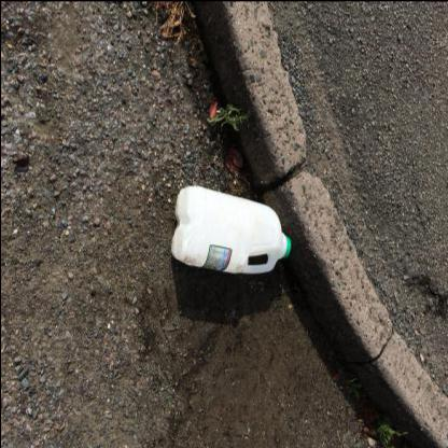

In [30]:
img = to_pil_image(img_tensor)
img

In [31]:
# TODO Upload a picture option

## Load Model

In [32]:
yolo = YOLOv1(in_channels=3, S=config.S, B=config.B, C=config.C).to(config.DEVICE)

optimizer = optim.Adam(
    yolo.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
if config.CON_TRAINING:
    load_checkpoint(file_name=config.LOAD_MODEL_FILE, yolo=yolo, optimizer=optimizer)



################################ 


-> Loading Model from checkpoint. Yolo_v1_taco_448_448_epoch_50_2025-04-27_loss_275.5003.pt

Loaded model.

################################ 



## Predict

In [33]:
# Add a batch to the img tensor
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 448, 448])

In [34]:
out = yolo(img_tensor.to(config.DEVICE))

In [35]:
out, out.shape

(tensor([[ 2.0538e-01,  1.6496e-01,  1.3499e-02,  2.2857e-01,  3.1490e-01,
          -3.8201e-01,  2.8955e-01, -2.1714e-01,  1.8990e-01, -1.7899e-01,
           1.3850e-01,  3.4603e-01,  4.5426e-01,  1.3273e-01,  1.2354e-01,
           2.4314e-01,  1.6657e-01,  2.3613e-01,  8.0808e-02,  1.1721e+00,
           1.0647e+00,  1.1352e-01,  3.0254e-01, -2.9234e-01,  8.7311e-01,
           1.0828e+00,  1.2252e-01,  7.4346e-02,  1.3688e-01,  1.4285e-01,
           2.8130e-01, -2.5774e-02, -1.0460e-01,  1.6098e-01,  7.2293e-01,
           1.5923e-01,  1.1422e-01, -1.0182e-01,  1.3876e-01,  1.0109e-02,
           2.1038e-01, -1.7835e-01, -8.4530e-02,  9.2740e-02,  1.3327e-01,
           6.2702e-01,  1.2127e-02,  1.0701e+00,  5.7488e-01,  1.4622e-01,
           4.4014e-01,  1.8086e-01,  1.1321e+00,  9.6706e-01,  3.4151e-01,
           1.9379e-01,  4.8341e-02,  3.7968e-01, -5.0423e-02,  7.6685e-02,
          -1.4520e-01,  6.1956e-02,  1.0910e+00, -1.5213e-01,  2.2722e-01,
           3.6887e-01, -6

Reshape output from (1, 1372) -> (1, 7, 7, 28)

In [36]:
# Reshape output
out = out.view(1, 7, 7, 28)
out, out.shape

(tensor([[[[ 2.0538e-01,  1.6496e-01,  1.3499e-02,  2.2857e-01,  3.1490e-01,
            -3.8201e-01,  2.8955e-01, -2.1714e-01,  1.8990e-01, -1.7899e-01,
             1.3850e-01,  3.4603e-01,  4.5426e-01,  1.3273e-01,  1.2354e-01,
             2.4314e-01,  1.6657e-01,  2.3613e-01,  8.0808e-02,  1.1721e+00,
             1.0647e+00,  1.1352e-01,  3.0254e-01, -2.9234e-01,  8.7311e-01,
             1.0828e+00,  1.2252e-01,  7.4346e-02],
           [ 1.3688e-01,  1.4285e-01,  2.8130e-01, -2.5774e-02, -1.0460e-01,
             1.6098e-01,  7.2293e-01,  1.5923e-01,  1.1422e-01, -1.0182e-01,
             1.3876e-01,  1.0109e-02,  2.1038e-01, -1.7835e-01, -8.4530e-02,
             9.2740e-02,  1.3327e-01,  6.2702e-01,  1.2127e-02,  1.0701e+00,
             5.7488e-01,  1.4622e-01,  4.4014e-01,  1.8086e-01,  1.1321e+00,
             9.6706e-01,  3.4151e-01,  1.9379e-01],
           [ 4.8341e-02,  3.7968e-01, -5.0423e-02,  7.6685e-02, -1.4520e-01,
             6.1956e-02,  1.0910e+00, -1.5213e-01

## Compute NMS

- Remove redundant bboxes that the model predicted.

In [37]:
%aimport utils.nms
%aimport utils.bboxes

from utils.nms import non_max_suppression
from utils.bboxes import extract_bboxes, reconstruct_tensor

In [38]:
# remove the batch dimension, view in matrices_visualize/nms_remove_dim.py
pred_bboxes = out.squeeze() # shape -> 7, 7, 28

# Extract all bounding boxes into a tensor
bboxes = extract_bboxes(pred_bboxes, config) # (N, 9) [ i, j, b, class_idx, pc, x, y, w, h]
bboxes

tensor([[ 3.0000e+00,  3.0000e+00,  0.0000e+00,  1.0000e+00,  2.3958e+00,
          1.1404e+00,  9.0117e-01,  8.4544e-01,  5.4606e-01],
        [ 3.0000e+00,  3.0000e+00,  1.0000e+00,  1.0000e+00,  2.3083e+00,
          1.0798e+00,  1.0296e+00,  8.2266e-01,  4.9606e-01],
        [ 4.0000e+00,  3.0000e+00,  1.0000e+00,  1.7000e+01,  6.9462e-01,
          1.2745e+00,  5.4847e-02,  8.8004e-01,  1.3534e-01],
        [ 3.0000e+00,  4.0000e+00,  0.0000e+00,  2.0000e+00,  6.3893e-01,
          9.1949e-01,  1.2592e+00,  5.4481e-01,  3.6765e-01],
        [ 3.0000e+00,  4.0000e+00,  1.0000e+00,  2.0000e+00,  5.6189e-01,
          6.9366e-01,  9.5856e-01,  2.4065e-01,  4.8248e-01],
        [ 3.0000e+00,  2.0000e+00,  0.0000e+00,  2.0000e+00,  4.2811e-01,
          1.1623e+00,  8.4248e-01,  6.1990e-01,  1.4242e-01],
        [ 5.0000e+00,  0.0000e+00,  1.0000e+00,  6.0000e+00,  3.7897e-01,
          9.4412e-01,  1.2023e+00,  2.1460e-01,  3.5309e-01],
        [ 0.0000e+00,  6.0000e+00,  0.0000e+00, 

In [39]:
bboxes_nms = non_max_suppression(
    pred_bboxes=bboxes,
    config=config
)
bboxes_nms # the bboxes from the models prediction

tensor([[ 3.0000,  3.0000,  0.0000,  1.0000,  2.3958,  1.1404,  0.9012,  0.8454,
          0.5461],
        [ 3.0000,  3.0000,  1.0000,  1.0000,  2.3083,  1.0798,  1.0296,  0.8227,
          0.4961],
        [ 3.0000,  4.0000,  0.0000,  2.0000,  0.6389,  0.9195,  1.2592,  0.5448,
          0.3677],
        [ 4.0000,  3.0000,  1.0000, 17.0000,  0.6946,  1.2745,  0.0548,  0.8800,
          0.1353]], device='mps:0', grad_fn=<StackBackward0>)

In [40]:
# NOTE: not necessary both pred and label tensors can be passed into extract_bboxes() then passed to plot
# Reconstruct the surviving bboxes 
# valid_bboxes = reconstruct_tensor(bboxes_nms, config)
# valid_bboxes

## Plot The Predicted And True Bounding boxes

In [41]:
%aimport utils.plot
from utils.plot import plot_bboxes

In [42]:
label = label.to(config.DEVICE)
label = extract_bboxes(label, config)

In [43]:
label_filter = label[label[:, 4] == 1]
label_filter # returns the bboxes from the label

tensor([[3.0000, 3.0000, 0.0000, 1.0000, 1.0000, 0.6010, 0.5757, 0.2668, 0.1971],
        [3.0000, 4.0000, 0.0000, 2.0000, 1.0000, 0.4591, 0.8281, 0.0192, 0.0529]],
       device='mps:0')

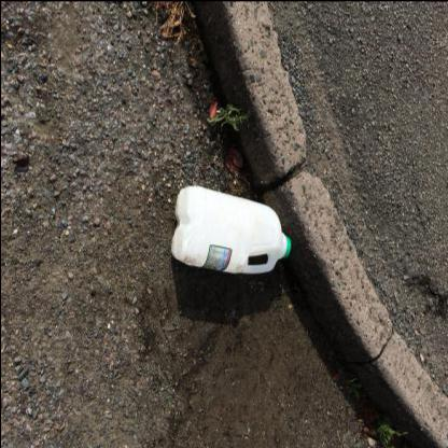

In [44]:
img

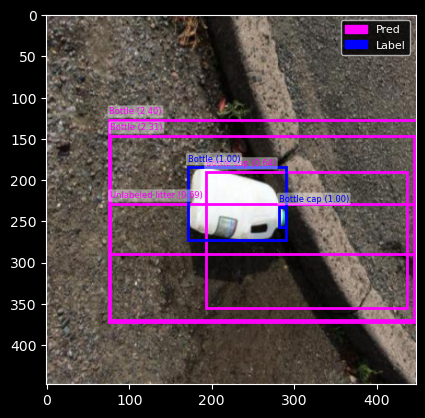

In [48]:
plot_bboxes(img=img, label_bboxes=label_filter, pred_bboxes=bboxes_nms, S=config.S)